In [14]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [15]:
# @title Initialize Config

import torch
class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.input_format = kwargs.get('input_format', 'csv')
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=150,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)

In [16]:
# @title Pre Window and save for reuse
import os
import shutil
import numpy as np
import pandas as pd

#import twdm for collab
from tqdm.notebook import tqdm


class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))



reshard = False

if reshard:

  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))


Training subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13']
Testing subjects: ['subject_1']


Processing train patients:   0%|          | 0/11 [00:00<?, ?it/s]

Processing sessions for subject_2:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_90_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_45_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_3:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach45_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach90_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T002_elbowrotation_slow_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_veryfast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_fast_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_normal_combined:   0%|          | 0/78 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T003_armswing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_fast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreachMax_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_slow_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Processing sessions for subject_4:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
from torch.utils.data import Dataset, DataLoader

class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])


        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])


Plotting KDE and time series for a single entry (Z-score normalized)...


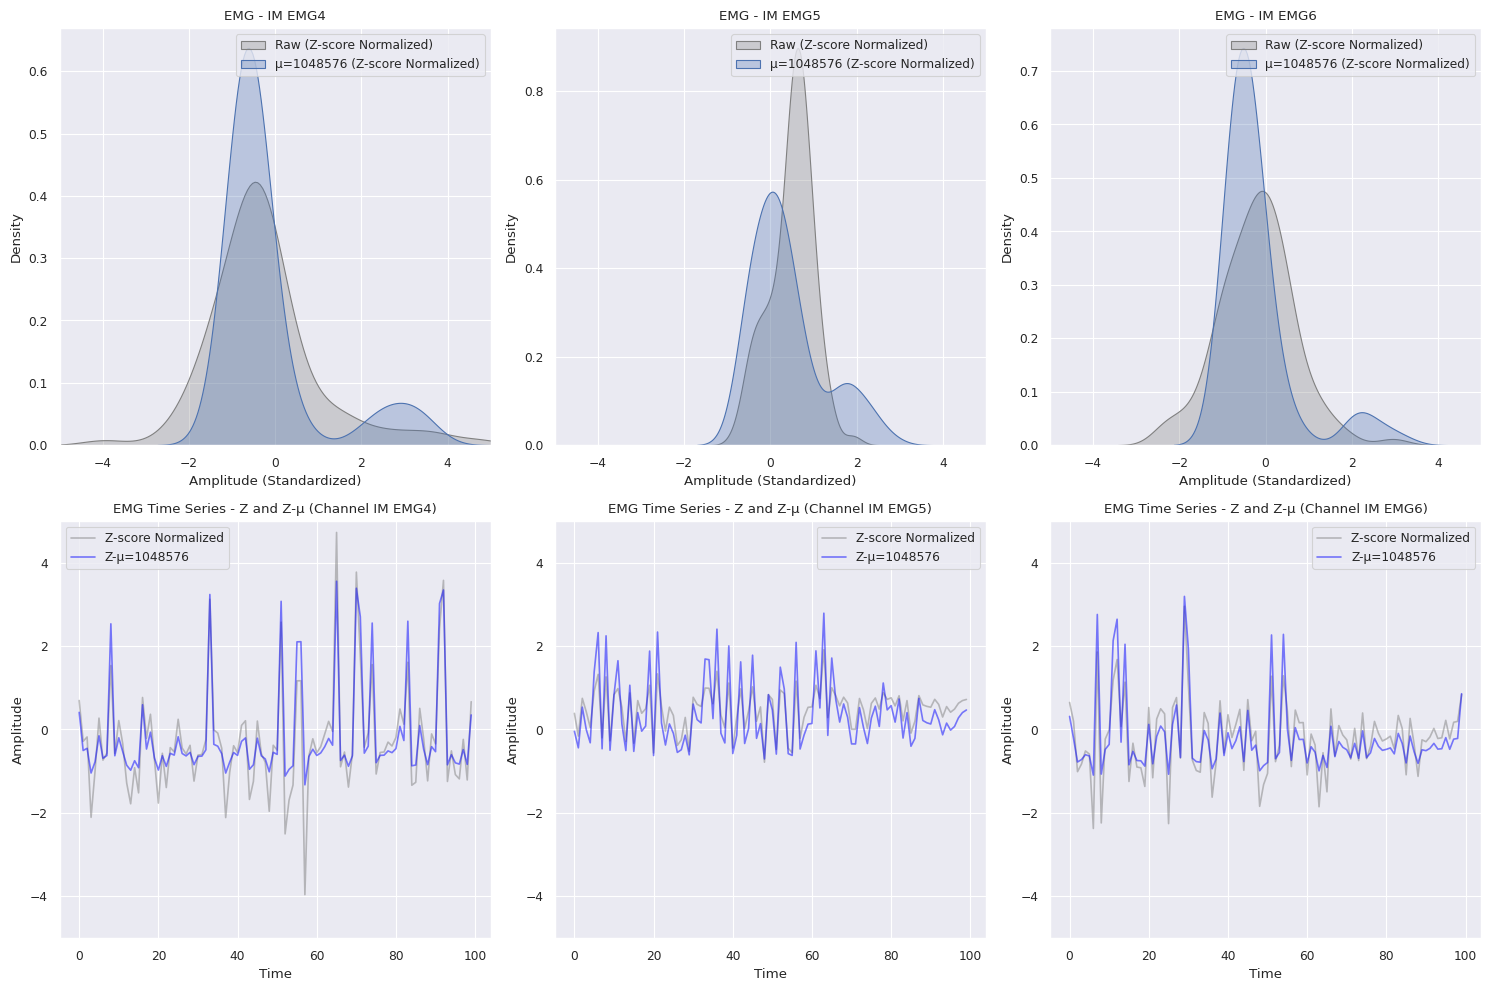

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def z_score_normalization(data):
    """Apply z-score normalization to standardize the data."""
    mean = np.mean(data, axis=(0, 1), keepdims=True)
    std = np.std(data, axis=(0, 1), keepdims=True)
    return (data - mean) / std

def plot_kde_and_timeseries_comparison(data_list, raw_data, label, mu_values, channel_names=None, entry_index=0):
    """Plot KDE for raw and μ-law normalized data, and time series for z-score and z-score μ-law normalized data for a specific entry in the batch."""
    channels = raw_data.shape[2]  # Get number of channels from the third axis (axis 2)

    # Select a single entry from the batch for visualization (e.g., first entry by default)
    raw_entry = raw_data[entry_index, :, :]
    data_entries = [data[entry_index, :, :] for data in data_list]

    # Standardize both raw and μ-law normalized data using z-score normalization
    raw_flat = z_score_normalization(raw_entry).reshape(-1, channels)  # Standardize and flatten raw data
    data_flat = [z_score_normalization(data).reshape(-1, channels) for data in data_entries]  # Standardize and flatten normalized data

    # Also create z-score normalized μ-law normalized data
    z_mu_data_flat = [z_score_normalization(data_flat[i]) for i in range(len(data_flat))]  # Z-score of μ-law normalized data

    # Define grid size based on the number of channels (1 row for 3 channels)
    rows = (channels + 2) // 3  # Adjust number of rows based on the number of channels
    fig, axs = plt.subplots(2 * rows, 3, figsize=(15, 10 * rows))  # Two sets of subplots (top: KDE, bottom: time series)
    axs = axs.ravel()  # Flatten the axis array for easy indexing

    # First set of subplots: KDE plots
    for i in range(channels):
        # Plot KDE for raw data with transparency
        sns.kdeplot(raw_flat[:, i], ax=axs[i], label='Raw (Z-score Normalized)', color='gray', fill=True, alpha=0.3, common_norm=False)

        # Plot KDE for μ-law normalized data for different μ values with transparency
        for j, data in enumerate(data_flat):
            sns.kdeplot(data[:, i], ax=axs[i], label=f'μ={mu_values[j]} (Z-score Normalized)', fill=True, alpha=0.3, common_norm=False)

        axs[i].set_title(f'{label} - {channel_names[i]}' if channel_names else f'{label} - Channel {i}')
        axs[i].set_xlabel('Amplitude (Standardized)')
        axs[i].set_ylabel('Density')


        # Set x-axis limits to +-5
        axs[i].set_xlim([-5, 5])

        axs[i].legend()

    # Second set of subplots: Time series plots
    for i in range(channels):
        # Get the time axis from the entry's data shape
        time_axis = np.arange(raw_entry.shape[0])

        # Plot time series for z-score normalized data in gray
        axs[i + channels].plot(time_axis, z_score_normalization(raw_entry)[:, i], label='Z-score Normalized', color='gray',alpha=.5)

        # Plot time series for z-score normalized μ-law normalized data in blue
        for j, data in enumerate(z_mu_data_flat):
            axs[i + channels].plot(time_axis, data.reshape(raw_entry.shape)[:, i], label=f'Z-μ={mu_values[j]}', color='blue',alpha=.5)

        axs[i + channels].set_title(f'{label} Time Series - Z and Z-μ (Channel {channel_names[i]})' if channel_names else f'{label} Time Series - Channel {i}')
        axs[i + channels].set_xlabel('Time')
        axs[i + channels].set_ylabel('Amplitude')

        # Standardize y-axis limits to [-5, 5]
        axs[i + channels].set_ylim([-5, 5])

        axs[i + channels].legend()

    plt.tight_layout()
    plt.show()

def mu_law_normalization(x, mu=2**20):
    """Applies μ-law normalization to the input."""
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

# Example usage:

# List to store normalized data for comparison
mu_values = [2**20]

# Normalize EMG data with different μ values
normalized_emg_list = [mu_law_normalization(emg.numpy(), mu=mu) for mu in mu_values]

# Plot KDE for raw and μ-law normalized EMG data, and time series for z-score normalized data for a single entry
print("Plotting KDE and time series for a single entry (Z-score normalized)...")
plot_kde_and_timeseries_comparison(normalized_emg_list, emg.numpy(), label="EMG", mu_values=mu_values, channel_names=config.channels_emg, entry_index=0)


In [ ]:
# @title Remake but with mu-noramlization
pbas
config.emg_transforms = [lambda x: mu_law_normalization(x, mu=mu) for mu in mu_values]

# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error
import numpy as np
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################




In [ ]:
import torch
import numpy as np
import os
import time
from tqdm.notebook import tqdm

import statistics

# Define the GHM-MSE Loss
class GHMMSELoss(torch.nn.Module):
    def __init__(self, bins=10, momentum=0.75):
        super(GHMMSELoss, self).__init__()
        self.bins = bins
        self.momentum = momentum
        self.edges = torch.linspace(0, 1, bins + 1)  # Initially on CPU
        self.acc_sum = torch.zeros(bins)  # Initially on CPU

    def forward(self, input, target):
        device = input.device  # Ensure we use the same device as input tensor
        self.edges = self.edges.to(device)  # Move edges to the same device
        self.acc_sum = self.acc_sum.to(device)  # Move acc_sum to the same device

        # Calculate the gradient norm (g)
        g = torch.sigmoid(2 * (input - target))
        g = g.detach()

        # Compute the gradient density
        n = input.size(0)
        inds = torch.bucketize(g, self.edges)
        total = torch.zeros_like(self.acc_sum)

        # Counting in each bin and calculate gradient harmonizing parameter (beta)
        for i in range(self.bins):
            total[i] = (inds == i + 1).float().sum()

        if self.training:
            self.acc_sum = self.momentum * self.acc_sum + (1 - self.momentum) * total
        acc_sum = self.acc_sum.clone().detach()

        # Beta calculation based on GD
        beta = torch.zeros_like(inds, dtype=torch.float32)
        for i in range(self.bins):
            beta[inds == i + 1] = n / (acc_sum[i] + 1e-6)

        loss = (beta * (input - target) ** 2).mean()
        return loss


# Define OHEM-MSE Loss
class OHEMMSELoss(torch.nn.Module):
    def __init__(self, ratio=0.7):
        super(OHEMMSELoss, self).__init__()
        self.ratio = ratio  # Store the ratio for selecting hard examples
        self.mse_loss = torch.nn.MSELoss()  # Initialize the mean squared error loss

    def forward(self, input, target):
        losses = self.mse_loss(input, target)  # Calculate MSE loss for each input-target pair
        num_hard_examples = int(self.ratio * losses.numel())  # Determine number of hard examples to select based on ratio
        hard_losses, _ = torch.topk(losses.view(-1), num_hard_examples)  # Select top-k hardest examples (highest losses)
        return hard_losses.mean()  # Return the mean of the selected hard losses


# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

# Training function
def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename,loss_function):

    model.to(device)
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            epoch_train_loss += loss.detach().cpu().numpy()
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)

        # Evaluate on test set and checkpoint every epoch
        avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_pccs.append(avg_test_pcc)
        test_rmses.append(avg_test_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(avg_train_loss)}, Validation Loss: {np.mean(avg_val_loss):.4f}", f"Test Loss: {np.mean(avg_test_loss):.4f}")
        print(f"Training RMSE: {np.mean(avg_train_rmse)}, Validation RMSE: {np.mean(avg_val_rmse):.4f}", f"Test RMSE: {np.mean(avg_test_rmse):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc)}, Validation PCC: {np.mean(avg_val_pcc):.4f}", f"Test PCC: {np.mean(avg_test_pcc):.4f}")

        if not os.path.exists(f"/content/MyDrive/MyDrive/models/{filename}"):
            os.makedirs(f"/content/MyDrive/MyDrive/models/{filename}")

        # Save checkpoint, including channel-wise metrics
        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            test_loss=avg_test_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            }
        )

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses



# Dictionary of models and their corresponding loss functions
model_configs = {
    'GHMMSELoss_nosubject5': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': GHMMSELoss()  # Use GHM-MSE Loss for this model
    },
    'OHEMMSELoss_nosubject5': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': OHEMMSELoss()  # Use OHEM-MSE Loss for this model
    },
    "RMSELoss_munormalization_nosubject5": {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': RMSELoss()  # Use RMSELoss for this model
    }
}

config.epochs = 100
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over each model and run the training with the corresponding loss function
for model_name, model_config in model_configs.items():
    model = model_config['model']
    loss_function = model_config['loss']  # Get the corresponding loss function

    print(f"Starting training for {model_name} using {loss_function.__class__.__name__}...")

    # Train the model using the common loaders, learning rate, and epochs from config
    model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(
        device,
        train_loader,
        val_loader,
        test_loader,
        config.lr,  # Learning rate from config
        config.epochs,  # Epochs from config
        model,
        model_name,  # Save checkpoint file named after the model
        loss_function  # Pass the specific loss function
    )

    print(f"Finished training for {model_name}.")


In [ ]:
# List to store normalized data for comparison
mu_values = [2**20]

print(emg.numpy().shape)

# Normalize EMG data with different μ values
normalized_emg_list = [mu_law_normalization(emg.numpy(), mu=mu) for mu in mu_values]

# Plot KDE for raw and μ-law normalized EMG data across the entire dataset using z-score normalization
print("Plotting KDE for raw and normalized EMG data (Z-score normalized)...")
plot_kde_comparison(normalized_emg_list, emg.numpy(), label="EMG", mu_values=mu_values, channel_names=config.channels_emg)